In [1]:
import pandas as pd 
import numpy as np                     # For mathematical calculations 
import seaborn as sns                  # For data visualization 
import matplotlib.pyplot as plt        # For plotting graphs 
%matplotlib inline 
import warnings                        # To ignore any warnings
warnings.filterwarnings("ignore")

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

/var/folders/_c/4zz82d6d5y73vn6kkbp72kjc0000gn/T/ipykernel_94142/3907666803.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# **Data**

For this problem, we have been given two CSV files: train and test

Train file will be used for training the model, i.e. our model will learn from this file. It contains all the independent variables and the target variable.

The test file contains all the independent variables, but not the target variable. We will apply the model to predict the target variable for the test data.

In [2]:
train=pd.read_csv("/Users/mihirvch/Downloads/archive(10)/loan_sanction_train.csv") 
test=pd.read_csv("/Users/mihirvch/Downloads/archive(10)/loan_sanction_test.csv")

In [3]:
#Renaming the columns to match HTML and Lambda function (One at a time for easier edits and bug fixes)
train.rename(columns={'Gender': 'gender'}, inplace=True)
train.rename(columns={'Married': 'married'}, inplace=True)
train.rename(columns={'Dependents': 'dependents'}, inplace=True)
train.rename(columns={'Education': 'education'}, inplace=True)
train.rename(columns={'Self_Employed': 'selfEmployed'}, inplace=True)
train.rename(columns={'ApplicantIncome': 'applicantIncome'}, inplace=True)
train.rename(columns={'CoapplicantIncome': 'coapplicantIncome'}, inplace=True)
train.rename(columns={'LoanAmount': 'loanAmount'}, inplace=True)
train.rename(columns={'Loan_Amount_Term': 'loanAmountTerm'}, inplace=True)
train.rename(columns={'Credit_History': 'creditHistory'}, inplace=True)
train.rename(columns={'Property_Area': 'propertyArea'}, inplace=True)
train.rename(columns={'Loan_Status': 'loanStatus'}, inplace=True)


test.rename(columns={'Gender': 'gender'}, inplace=True)
test.rename(columns={'Married': 'married'}, inplace=True)
test.rename(columns={'Dependents': 'dependents'}, inplace=True)
test.rename(columns={'Education': 'education'}, inplace=True)
test.rename(columns={'Self_Employed': 'selfEmployed'}, inplace=True)
test.rename(columns={'ApplicantIncome': 'applicantIncome'}, inplace=True)
test.rename(columns={'CoapplicantIncome': 'coapplicantIncome'}, inplace=True)
test.rename(columns={'LoanAmount': 'loanAmount'}, inplace=True)
test.rename(columns={'Loan_Amount_Term': 'loanAmountTerm'}, inplace=True)
test.rename(columns={'Credit_History': 'creditHistory'}, inplace=True)
test.rename(columns={'Property_Area': 'propertyArea'}, inplace=True)

In [4]:
train.columns

Index(['Loan_ID', 'gender', 'married', 'dependents', 'education',
       'selfEmployed', 'applicantIncome', 'coapplicantIncome', 'loanAmount',
       'loanAmountTerm', 'creditHistory', 'propertyArea', 'loanStatus'],
      dtype='object')

In [5]:
test.columns

Index(['Loan_ID', 'gender', 'married', 'dependents', 'education',
       'selfEmployed', 'applicantIncome', 'coapplicantIncome', 'loanAmount',
       'loanAmountTerm', 'creditHistory', 'propertyArea'],
      dtype='object')

In [6]:
# Print data types for each variable
train.dtypes

Loan_ID               object
gender                object
married               object
dependents            object
education             object
selfEmployed          object
applicantIncome        int64
coapplicantIncome    float64
loanAmount           float64
loanAmountTerm       float64
creditHistory        float64
propertyArea          object
loanStatus            object
dtype: object

In [7]:
train.shape, test.shape

((614, 13), (367, 12))

In [8]:
train['loanStatus'].value_counts()

loanStatus
Y    422
N    192
Name: count, dtype: int64

In [9]:
# Normalize can be set to True to print proportions instead of number
train['loanStatus'].value_counts(normalize=True)

loanStatus
Y    0.687296
N    0.312704
Name: proportion, dtype: float64

422(around 69%) people out of 614 got the approval.

In [10]:
train.head()

,Loan_ID,gender,married,dependents,education,selfEmployed,applicantIncome,coapplicantIncome,loanAmount,loanAmountTerm,creditHistory,propertyArea,loanStatus
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


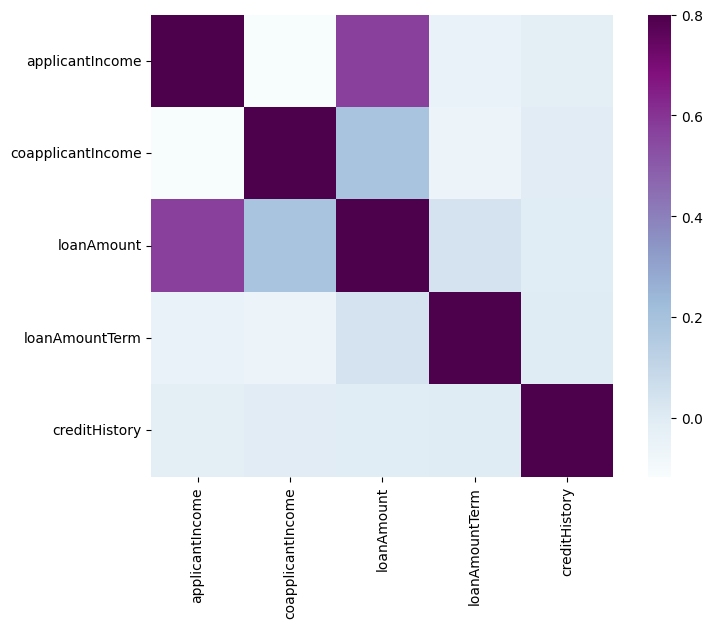

In [11]:
# Select numerical columns
numerical_columns = train.select_dtypes(include=['number'])

# Calculate the correlation matrix
matrix = numerical_columns.corr()

# Create a heatmap
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(matrix, vmax=0.8, square=True, cmap="BuPu")

# Show the plot
plt.show()

We see that the most correlated variables are (ApplicantIncome – LoanAmount) and (Credit_History – Loan_Status). LoanAmount is also correlated with CoapplicantIncome.

> # **Missing Value and Outlier Treatment**

In [12]:
train.isnull().sum()

Loan_ID               0
gender               13
married               3
dependents           15
education             0
selfEmployed         32
applicantIncome       0
coapplicantIncome     0
loanAmount           22
loanAmountTerm       14
creditHistory        50
propertyArea          0
loanStatus            0
dtype: int64

* For numerical variables: imputation using mean or median
* For categorical variables: imputation using mode

In [13]:
train['gender'].fillna(train['gender'].mode()[0], inplace=True)
train['married'].fillna(train['married'].mode()[0], inplace=True)
train['dependents'].fillna(train['dependents'].mode()[0], inplace=True)
train['selfEmployed'].fillna(train['selfEmployed'].mode()[0], inplace=True)
train['creditHistory'].fillna(train['creditHistory'].mode()[0], inplace=True)

In [14]:
train['loanAmountTerm'].value_counts()

loanAmountTerm
360.0    512
180.0     44
480.0     15
300.0     13
240.0      4
84.0       4
120.0      3
60.0       2
36.0       2
12.0       1
Name: count, dtype: int64

It can be seen that in the loan amount term variable, the value of 360 is repeated the most. So we will replace the missing values in this variable using the mode of this variable.

In [15]:
train['loanAmountTerm'].fillna(train['loanAmountTerm'].mode()[0], inplace=True)

In [16]:
train['loanAmount'].fillna(train['loanAmount'].median(), inplace=True)

In [17]:
train.isnull().sum()

Loan_ID              0
gender               0
married              0
dependents           0
education            0
selfEmployed         0
applicantIncome      0
coapplicantIncome    0
loanAmount           0
loanAmountTerm       0
creditHistory        0
propertyArea         0
loanStatus           0
dtype: int64

In [18]:
test['gender'].fillna(train['gender'].mode()[0], inplace=True) 
test['dependents'].fillna(train['dependents'].mode()[0], inplace=True) 
test['selfEmployed'].fillna(train['selfEmployed'].mode()[0], inplace=True) 
test['creditHistory'].fillna(train['creditHistory'].mode()[0], inplace=True) 
test['loanAmountTerm'].fillna(train['loanAmountTerm'].mode()[0], inplace=True) 
test['loanAmount'].fillna(train['loanAmount'].median(), inplace=True)

> # **Outlier Treatment**

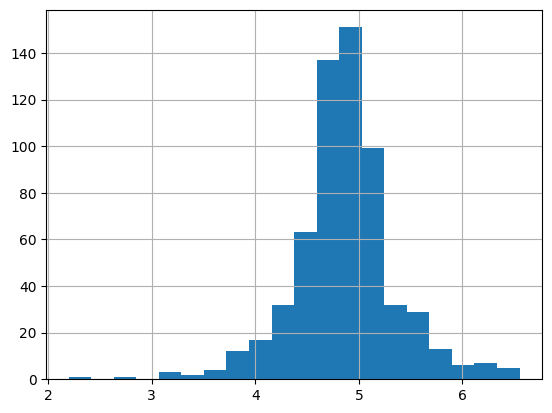

In [19]:
train['loanAmount_log'] = np.log(train['loanAmount']) 
train['loanAmount_log'].hist(bins=20) 
test['loanAmount_log'] = np.log(test['loanAmount'])

Now the distribution looks much closer to normal and the effect of extreme values has been significantly subsided.

> # **Model Building: Random Forest**

* Logistic Regression is a classification algorithm. It is used to predict a binary outcome (1 / 0, Yes / No, True / False) given a set of independent variables.
* Logistic regression is an estimation of the Logit function. The logit function is simply a log of odds in favor of the event.
* This function creates an S-shaped curve with the probability estimate, which is very similar to the required stepwise function

In [20]:
train=train.drop('Loan_ID',axis=1) 
test=test.drop('Loan_ID',axis=1)

In [21]:
train

,gender,married,dependents,education,selfEmployed,applicantIncome,coapplicantIncome,loanAmount,loanAmountTerm,creditHistory,propertyArea,loanStatus,loanAmount_log
0,Male,No,0,Graduate,No,5849,0.0,128.0,360.0,1.0,Urban,Y,4.852030
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,4.852030
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,4.189655
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,4.787492
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,4.948760
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y,4.262680
610,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y,3.688879
611,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y,5.533389
612,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y,5.231109


In [22]:
X = train.drop('loanStatus', axis=1)
y = train['loanStatus']


Now we will make dummy variables for the categorical variables. A dummy variable turns categorical variables into a series of 0 and 1, making them a lot easier to quantify and compare.

Once we apply dummies to a variable lets say 'Gender', it will convert the “Gender” variable into two variables(Gender_Male and Gender_Female), one for each class, i.e. Male and Female.
Gender_Male will have a value of 0 if the gender is Female and a value of 1 if the gender is Male.

In [23]:
X=pd.get_dummies(X) 
train=pd.get_dummies(train) 
test=pd.get_dummies(test)

In [24]:
from sklearn.model_selection import train_test_split
x_train, x_cv, y_train, y_cv = train_test_split(X,y, test_size =0.2)

 # **Random Forest Using Stratified k-folds Cross-validation**

* Stratification is the process of rearranging the data so as to ensure that each fold is a good representative of the whole.
* For example, in a binary classification problem where each class comprises 50% of the data, it is best to arrange the data such that in every fold, each class comprises about half the instances.
* It is generally a better approach when dealing with both bias and variance.
* A randomly selected fold might not adequately represent the minor class, particularly in cases where there is a huge class imbalance.

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
i=1 
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True) 
for train_index,test_index in kf.split(X,y): 
    print('n{} of kfold {}'.format(i,kf.n_splits)) 
    xtr,xvl = X.loc[train_index],X.loc[test_index] 
    ytr,yvl = y[train_index],y[test_index] 
    model = RandomForestClassifier(random_state=1, max_depth=10)     
    model.fit(xtr, ytr) 
    pred_test = model.predict(xvl) 
    score = accuracy_score(yvl,pred_test) 
    print('accuracy_score',score) 
    i+=1 
pred_test = model.predict(test)

n1 of kfold 5
accuracy_score 0.8130081300813008
n2 of kfold 5
accuracy_score 0.8373983739837398
n3 of kfold 5
accuracy_score 0.7804878048780488
n4 of kfold 5
accuracy_score 0.8130081300813008
n5 of kfold 5
accuracy_score 0.7622950819672131


In [27]:
from sklearn.model_selection import GridSearchCV

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


paramgrid = {'max_depth': list(range(1, 20, 2)),
             'n_estimators': list(range(1, 200, 20))}

grid_search = GridSearchCV(RandomForestClassifier(random_state=1), paramgrid)

# Fit the grid search model
grid_search.fit(x_train, y_train)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'max_depth': 7, 'n_estimators': 141}


In [29]:
# Estimating the optimized value

grid_search.best_estimator_

RandomForestClassifier(max_depth=7, n_estimators=141, random_state=1)

In [31]:
i = 1
kf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

for train_index, test_index in kf.split(X, y):
    print('Fold {} of {} k-folds'.format(i, kf.n_splits))
    xtr, xvl = X.loc[train_index], X.loc[test_index]
    ytr, yvl = y[train_index], y[test_index]

    model = RandomForestClassifier(random_state=1, max_depth=7, n_estimators=141)
    model.fit(xtr, ytr)

    pred_test = model.predict(xvl)
    score = accuracy_score(yvl, pred_test)
    print('Accuracy Score:', score)

    i += 1

# Assuming 'test' is your test data
pred_test = model.predict(test)
pred_prob_test = model.predict_proba(test)[:, 1]

Fold 1 of 5 k-folds
Accuracy Score: 0.8130081300813008
Fold 2 of 5 k-folds
Accuracy Score: 0.8455284552845529
Fold 3 of 5 k-folds
Accuracy Score: 0.7967479674796748
Fold 4 of 5 k-folds
Accuracy Score: 0.8048780487804879
Fold 5 of 5 k-folds
Accuracy Score: 0.7786885245901639


Saving Joblib to S3

In [ ]:
import joblib
from sagemaker.s3 import S3Uploader

model_filename = 'model.joblib'
joblib.dump(model, model_filename)

# Upload the model artifacts to S3
s3_model_path = S3Uploader.upload(model_filename, 's3://model-bucket-mihir/model-path/')

In [ ]:
import joblib
from sagemaker.s3 import S3Uploader

model_filename = 'model.joblib'
joblib.dump(model, model_filename)

# Upload the model artifacts to S3
s3_model_path = S3Uploader.upload(model_filename, 's3://model-bucket-mihir/model-path/')